Starting the process...
requirements.txt file created successfully!
Loading MRPC dataset from nyu-mll/glue...
Training: 3668 examples
Validation: 408 examples
Test: 1725 examples
Tokenizing the dataset...

=== Experiment 1: 1 epoch, learning rate 0.01, batch size 16 ===



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train/loss,██▆▇▆▄▇▄▆▅▅▄▆▅▇▆▄▃▃▄▂▃▄▃▅▇█▂▅▄▂▁▃▅▃▆▂▁▃▆
validation/accuracy,▁
train/loss,0.54398
validation/accuracy,0.81618


Successfully initialized Weights & Biases
Starting training on cuda...
Epoch 1/1 - Average loss: 0.8214
Epoch 1/1 - Validation Accuracy: 0.6838
New best model with accuracy: 0.6838
Test Accuracy: 0.6649


test/accuracy,▁
train/loss,█▂▂▂▂▂▂▁▃▄▁▂▁▂▄▂▃▁▂▁▁▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▁▂▁▂
validation/accuracy,▁
test/accuracy,0.66493
train/loss,0.75716
validation/accuracy,0.68382


Saved the best model to ./modelepoch1lr0.01_batchsize16
Added results to res.txt

=== Experiment 2: 3 epochs, learning rate 4e-5, batch size 16 ===



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully initialized Weights & Biases
Starting training on cuda...
Epoch 1/3 - Average loss: 0.5689
Epoch 1/3 - Validation Accuracy: 0.8333
New best model with accuracy: 0.8333
Epoch 2/3 - Average loss: 0.3044
Epoch 2/3 - Validation Accuracy: 0.8603
New best model with accuracy: 0.8603
Epoch 3/3 - Average loss: 0.1025
Epoch 3/3 - Validation Accuracy: 0.8578
Test Accuracy: 0.8441


test/accuracy,▁
train/loss,▇▆▆▆▆▅█▅▄▆▂▄▂▄▄▃▄▄▃▄▃▂▂▂▂▂▁▂▁▁▂▁▁▁▄▁▂▁▂▁
validation/accuracy,▁█▇
test/accuracy,0.84406
train/loss,0.00502
validation/accuracy,0.85784


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved the best model to ./modelepoch3lr4e-05_batchsize16
Added results to res.txt

=== Experiment 3: 5 epochs, learning rate 5e-5, batch size 16 ===



Successfully initialized Weights & Biases
Starting training on cuda...
Epoch 1/5 - Average loss: 0.5783
Epoch 1/5 - Validation Accuracy: 0.8162
New best model with accuracy: 0.8162
Epoch 2/5 - Average loss: 0.3378
Epoch 2/5 - Validation Accuracy: 0.8652
New best model with accuracy: 0.8652
Epoch 3/5 - Average loss: 0.1352
Epoch 3/5 - Validation Accuracy: 0.8627
Epoch 4/5 - Average loss: 0.0508
Epoch 4/5 - Validation Accuracy: 0.8652
Epoch 5/5 - Average loss: 0.0217
Epoch 5/5 - Validation Accuracy: 0.8554
Test Accuracy: 0.8307


test/accuracy,▁
train/loss,█▇▆▅▇██▆▅█▄▄▄▄▆▅▆▄▃▂▂▂▁▂▂▃▁▁▂▁▁▁▂▂▁▁▅▁▁▁
validation/accuracy,▁███▇
test/accuracy,0.83072
train/loss,0.00305
validation/accuracy,0.85539


Saved the best model to ./modelepoch5lr5e-05_batchsize16
Added results to res.txt
train_loss.png graph created successfully

The best model is: ./modelepoch5lr5e-05_batchsize16 with validation accuracy of 0.8652 and test accuracy of 0.8307

=== Finding examples where models completely disagree (one predicts 0, one predicts 1) ===

Analysis complete. Found 128 examples where models completely disagree.
Results saved to complete_disagreement_examples.txt

Examples where best model correctly predicted and worst model was wrong:

Example 1:
Sentence 1: Magnarelli said Racicot hated the Iraqi regime and looked forward to using his long years of training in the war .
Sentence 2: His wife said he was " 100 percent behind George Bush " and looked forward to using his years of training in the war .
True label: 0 (Not paraphrase)
Best model: Correct (0) with confidence 0.9919
Worst model: Wrong (1) with confidence 0.6854

Example 2:
Sentence 1: The dollar was at 116.92 yen against the yen , flat

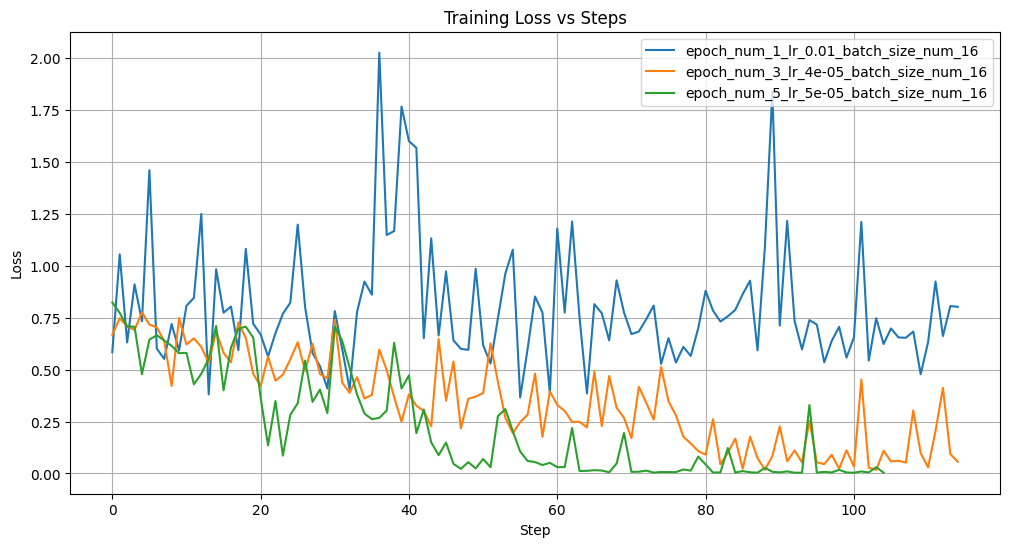

In [7]:
# Installing required packages
!pip install transformers datasets torch wandb scikit-learn matplotlib

# Importing all required libraries
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import wandb

# Setting constants - you can change them here
MAX_TRAIN_SAMPLES = -1  # All training examples
MAX_EVAL_SAMPLES = -1   # All validation examples
MAX_TEST_SAMPLES = -1   # All test examples

# Setting random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Creating requirements.txt file
def create_requirements_file():
    with open("requirements.txt", "w") as f:
        f.write("transformers>=4.28.0\n")
        f.write("datasets>=2.12.0\n")
        f.write("torch>=2.0.0\n")
        f.write("wandb>=0.15.0\n")
        f.write("scikit-learn>=1.2.0\n")
        f.write("numpy>=1.24.0\n")
        f.write("matplotlib>=3.5.0\n")
    print("requirements.txt file created successfully!")

# Loading MRPC dataset
def load_mrpc_dataset(max_train_samples=-1, max_eval_samples=-1, max_test_samples=-1):
    print("Loading MRPC dataset from nyu-mll/glue...")
    dataset = load_dataset("nyu-mll/glue", "mrpc")

    # Limiting the number of examples if required
    if max_train_samples > 0 and max_train_samples < len(dataset["train"]):
        dataset["train"] = dataset["train"].select(range(max_train_samples))

    if max_eval_samples > 0 and max_eval_samples < len(dataset["validation"]):
        dataset["validation"] = dataset["validation"].select(range(max_eval_samples))

    if max_test_samples > 0 and max_test_samples < len(dataset["test"]):
        dataset["test"] = dataset["test"].select(range(max_test_samples))

    print(f"Training: {len(dataset['train'])} examples")
    print(f"Validation: {len(dataset['validation'])} examples")
    print(f"Test: {len(dataset['test'])} examples")

    return dataset

# Tokenizing the dataset
def tokenize_dataset(dataset, tokenizer):
    def tokenize_function(examples):
        # Tokenization with truncation but without padding (dynamic padding)
        return tokenizer(
            examples["sentence1"],
            examples["sentence2"],
            truncation=True,
            padding=False,  # Dynamic padding will be done by the data collator
            max_length=128
        )

    print("Tokenizing the dataset...")
    tokenized_datasets = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=["idx", "sentence1", "sentence2"]
    )

    # Renaming the label column
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

    return tokenized_datasets

# Training the model
def train_model(model, tokenizer, train_dataset, eval_dataset, test_dataset, num_epochs, learning_rate, batch_size):
    # Initializing wandb for tracking
    run_name = f"epoch_num_{num_epochs}_lr_{learning_rate}_batch_size{batch_size}"
    try:
        wandb.init(project="mrpc-paraphrase-detection", name=run_name)
        use_wandb = True
        print("Successfully initialized Weights & Biases")
    except Exception as e:
        print(f"Error initializing Weights & Biases: {e}")
        print("Continuing without wandb tracking")
        use_wandb = False

    # Creating data collator for dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Creating data loaders
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    # Preparing optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    num_training_steps = num_epochs * len(train_dataloader)
    num_warmup_steps = int(0.1 * num_training_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_accuracy = 0.0
    best_model_state = None
    step_counter = 0
    model_save_path = f"./modelepoch{num_epochs}lr{learning_rate}_batchsize{batch_size}"

    # Tracking loss for plotting
    losses = []

    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss

            # Tracking loss
            current_loss = loss.item()
            losses.append(current_loss)
            epoch_loss += current_loss

            # Logging training loss to wandb
            if use_wandb:
                wandb.log({"train/loss": current_loss}, step=step_counter)
            step_counter += 1

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average loss: {avg_epoch_loss:.4f}")

        # Validation
        model.eval()
        val_preds = []
        val_labels = []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.no_grad():
                outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            val_preds.extend(predictions.cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())

        # Calculating validation accuracy
        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Accuracy: {val_accuracy:.4f}")

        # Logging validation accuracy to wandb
        if use_wandb:
            wandb.log({"validation/accuracy": val_accuracy}, step=step_counter)

        # Saving the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
            print(f"New best model with accuracy: {best_accuracy:.4f}")

    # Testing on test set
    model.eval()
    test_preds = []
    test_labels = []

    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(batch["labels"].cpu().numpy())

    # Calculating test accuracy
    test_accuracy = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Logging test accuracy to wandb
    if use_wandb:
        wandb.log({"test/accuracy": test_accuracy}, step=step_counter)

    # Ending wandb run
    if use_wandb:
        wandb.finish()

    # Saving the best model
    os.makedirs(model_save_path, exist_ok=True)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Saved the best model to {model_save_path}")

    # Saving results to res.txt
    with open("res.txt", "a") as f:
        f.write(f"epoch_num: {num_epochs}, lr: {learning_rate}, batch_size: {batch_size}, eval_acc: {best_accuracy:.4f}, test_acc: {test_accuracy:.4f}\n")
    print(f"Added results to res.txt")

    return best_accuracy, test_accuracy, model_save_path, losses

# Generating predictions
def generate_predictions(model, tokenizer, test_dataset, original_test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    print("Creating predictions without padding...")

    all_predictions = []

    # Processing each example separately without padding
    for i in range(len(test_dataset)):
        # Getting the tokenized input
        item = test_dataset[i]

        # Creating tensors
        input_ids = torch.tensor(item["input_ids"], dtype=torch.long).unsqueeze(0)
        attention_mask = torch.tensor(item["attention_mask"], dtype=torch.long).unsqueeze(0)

        # Moving to device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Making prediction
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
        all_predictions.append(prediction)

    print(f"Generated {len(all_predictions)} predictions")

    # Writing predictions to file
    with open("predictions.txt", "w", encoding="utf-8") as f:
        for i, pred in enumerate(all_predictions):
            sentence1 = original_test_data[i]["sentence1"]
            sentence2 = original_test_data[i]["sentence2"]
            f.write(f"{sentence1}###{sentence2}###{pred}\n")

    print("Predictions saved to predictions.txt")
    return all_predictions
# הוסף את הפונקציה החדשה כאן
def analyze_model_differences(best_model, worst_model, tokenizer, validation_dataset, original_validation_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)
    worst_model.to(device)

    best_model.eval()
    worst_model.eval()

    results = []

    for i in range(len(validation_dataset)):
        # Get example and original text
        item = validation_dataset[i]
        original_example = original_validation_data[i]

        # Create tensors
        input_ids = torch.tensor(item["input_ids"], dtype=torch.long).unsqueeze(0).to(device)
        attention_mask = torch.tensor(item["attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
        true_label = item["labels"]

        # Get predictions from both models
        with torch.no_grad():
            best_outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
            worst_outputs = worst_model(input_ids=input_ids, attention_mask=attention_mask)

        best_pred = torch.argmax(best_outputs.logits, dim=-1).item()
        worst_pred = torch.argmax(worst_outputs.logits, dim=-1).item()

        # Calculate confidence scores
        best_probs = torch.nn.functional.softmax(best_outputs.logits, dim=-1)
        worst_probs = torch.nn.functional.softmax(worst_outputs.logits, dim=-1)

        best_confidence = best_probs[0][best_pred].item()
        worst_confidence = worst_probs[0][worst_pred].item()

        # Store only examples where best model is correct and worst model is wrong
        if best_pred == true_label and worst_pred != true_label:
            results.append({
                "sentence1": original_example["sentence1"],
                "sentence2": original_example["sentence2"],
                "true_label": true_label,
                "best_confidence": best_confidence,
                "worst_confidence": worst_confidence
            })

    # Save results to a file
    with open("model_comparison.txt", "w", encoding="utf-8") as f:
        f.write(f"Found {len(results)} examples where best model succeeded but worst model failed\n\n")

        for i, example in enumerate(results):
            f.write(f"Example {i+1}:\n")
            f.write(f"Sentence 1: {example['sentence1']}\n")
            f.write(f"Sentence 2: {example['sentence2']}\n")
            f.write(f"True label: {example['true_label']} " +
                   f"({'Paraphrase' if example['true_label'] == 1 else 'Not paraphrase'})\n")
            f.write(f"Best model confidence: {example['best_confidence']:.4f}\n")
            f.write(f"Worst model confidence: {example['worst_confidence']:.4f}\n\n")

    return results

def analyze_model_differences_complete_disagreement(best_model, worst_model, tokenizer, validation_dataset, original_validation_data):
    """
    Find examples where the best model is correct and the worst model is wrong (with completely different predictions)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)
    worst_model.to(device)

    best_model.eval()
    worst_model.eval()

    disagreement_examples = []  # Store examples where models completely disagree

    for i in range(len(validation_dataset)):
        # Get example and original text
        item = validation_dataset[i]
        original_example = original_validation_data[i]

        # Create tensors
        input_ids = torch.tensor(item["input_ids"], dtype=torch.long).unsqueeze(0).to(device)
        attention_mask = torch.tensor(item["attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
        true_label = item["labels"]

        # Get predictions from both models
        with torch.no_grad():
            best_outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
            worst_outputs = worst_model(input_ids=input_ids, attention_mask=attention_mask)

        best_pred = torch.argmax(best_outputs.logits, dim=-1).item()
        worst_pred = torch.argmax(worst_outputs.logits, dim=-1).item()

        # Calculate confidence scores
        best_probs = torch.nn.functional.softmax(best_outputs.logits, dim=-1)
        worst_probs = torch.nn.functional.softmax(worst_outputs.logits, dim=-1)

        best_confidence = best_probs[0][best_pred].item()
        worst_confidence = worst_probs[0][worst_pred].item()

        # Store only examples where best model is correct, worst model is wrong, and they completely disagree
        if best_pred == true_label and worst_pred != true_label and best_pred != worst_pred:
            disagreement_examples.append({
                "id": i,
                "sentence1": original_example["sentence1"],
                "sentence2": original_example["sentence2"],
                "true_label": true_label,
                "best_pred": best_pred,
                "worst_pred": worst_pred,
                "best_confidence": best_confidence,
                "worst_confidence": worst_confidence,
                "sentence1_length": len(original_example["sentence1"].split()),
                "sentence2_length": len(original_example["sentence2"].split())
            })

    # Save results to a file
    with open("complete_disagreement_examples.txt", "w", encoding="utf-8") as f:
        f.write(f"Found {len(disagreement_examples)} examples where best model is correct and worst model is wrong\n\n")

        for i, example in enumerate(disagreement_examples):
            f.write(f"Example {i+1}:\n")
            f.write(f"Sentence 1: {example['sentence1']}\n")
            f.write(f"Sentence 2: {example['sentence2']}\n")
            f.write(f"Sentence 1 length: {example['sentence1_length']} words\n")
            f.write(f"Sentence 2 length: {example['sentence2_length']} words\n")
            f.write(f"True label: {example['true_label']} ({'Paraphrase' if example['true_label'] == 1 else 'Not paraphrase'})\n")
            f.write(f"Best model prediction: {example['best_pred']} ({'Paraphrase' if example['best_pred'] == 1 else 'Not paraphrase'})\n")
            f.write(f"Worst model prediction: {example['worst_pred']} ({'Paraphrase' if example['worst_pred'] == 1 else 'Not paraphrase'})\n")
            f.write(f"Best model confidence: {example['best_confidence']:.4f}\n")
            f.write(f"Worst model confidence: {example['worst_confidence']:.4f}\n\n")

    return disagreement_examples

# Creating loss plot
def create_loss_plot(all_losses, all_configs):
    plt.figure(figsize=(12, 6))
    plt.title('Training Loss vs Steps')

    for i, (losses, config) in enumerate(zip(all_losses, all_configs)):
        # For a smoother graph, selecting a sample of points
        if len(losses) > 100:
            step = max(1, len(losses) // 100)
            indices = np.arange(0, len(losses), step)
            selected_losses = [losses[j] for j in indices]
        else:
            selected_losses = losses

        # Plotting the graph with appropriate label format
        plt.plot(
            selected_losses,
            label=f"epoch_num_{config['num_epochs']}_lr_{config['lr']}_batch_size_num_{config['batch_size']}"
        )

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('train_loss.png')
    print("train_loss.png graph created successfully")

# Creating ex1.py file for submission
def create_ex1_file():
    ex1_code = '''#!/usr/bin/env python
"""
Fine-tuning BERT for paraphrase detection on the MRPC dataset.
"""

import os
import sys
import argparse
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def parse_args():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser(description="Fine-tune BERT on MRPC dataset")
    parser.add_argument("--max_train_samples", type=int, default=-1,
                        help="Max number of training samples to use (-1 for all)")
    parser.add_argument("--max_eval_samples", type=int, default=-1,
                        help="Max number of evaluation samples to use (-1 for all)")
    parser.add_argument("--max_predict_samples", type=int, default=-1,
                        help="Max number of prediction samples to use (-1 for all)")
    parser.add_argument("--num_train_epochs", type=int, default=3,
                        help="Number of training epochs")
    parser.add_argument("--lr", type=float, default=5e-5,
                        help="Learning rate")
    parser.add_argument("--batch_size", type=int, default=16,
                        help="Batch size for training and evaluation")
    parser.add_argument("--do_train", action="store_true",
                        help="Whether to run training")
    parser.add_argument("--do_predict", action="store_true",
                        help="Whether to run predictions on the test set")
    parser.add_argument("--model_path", type=str, default=None,
                        help="Path to model to use for predictions")

    return parser.parse_args()

def load_mrpc_dataset(max_train_samples=-1, max_eval_samples=-1, max_predict_samples=-1):
    """
    Load the MRPC dataset from Hugging Face - specifically from nyu-mll/glue
    """
    logger.info("Loading MRPC dataset from nyu-mll/glue...")
    dataset = load_dataset("nyu-mll/glue", "mrpc")

    # Apply sample limits if specified
    if max_train_samples > 0 and max_train_samples < len(dataset["train"]):
        dataset["train"] = dataset["train"].select(range(max_train_samples))

    if max_eval_samples > 0 and max_eval_samples < len(dataset["validation"]):
        dataset["validation"] = dataset["validation"].select(range(max_eval_samples))

    if max_predict_samples > 0 and max_predict_samples < len(dataset["test"]):
        dataset["test"] = dataset["test"].select(range(max_predict_samples))

    logger.info(f"Train: {len(dataset['train'])} examples")
    logger.info(f"Validation: {len(dataset['validation'])} examples")
    logger.info(f"Test: {len(dataset['test'])} examples")

    return dataset

def tokenize_dataset(dataset, tokenizer):
    """
    Tokenize the dataset for BERT with dynamic padding.
    """
    def tokenize_function(examples):
        # Tokenize the texts with truncation but no padding (dynamic padding)
        return tokenizer(
            examples["sentence1"],
            examples["sentence2"],
            truncation=True,
            padding=False,  # Dynamic padding will be applied by the data collator
            max_length=128
        )

    logger.info("Tokenizing dataset...")
    tokenized_datasets = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=["idx", "sentence1", "sentence2"]
    )

    # Rename label column to labels (the default expected by the models)
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

    return tokenized_datasets

def train_model(model, tokenizer, train_dataset, eval_dataset, test_dataset, args):
    """
    Train the model and evaluate on validation and test sets.
    """
    # Initialize wandb for tracking
    run_name = f"epochnum{args.num_train_epochs}lr{args.lr}_batchsize{args.batch_size}"
    try:
        import wandb
        wandb.init(project="mrpc-paraphrase-detection", name=run_name)
        use_wandb = True
        logger.info("Successfully initialized Weights & Biases tracking")
    except Exception as e:
        logger.warning(f"Error initializing Weights & Biases: {e}")
        logger.info("Continuing without wandb tracking")
        use_wandb = False

    # Create data collator for dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Create data loaders
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=args.batch_size,
        collate_fn=data_collator
    )

    eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=args.batch_size,
        collate_fn=data_collator
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        collate_fn=data_collator
    )

    # Prepare optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=args.lr)

    num_training_steps = args.num_train_epochs * len(train_dataloader)
    num_warmup_steps = int(0.1 * num_training_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_accuracy = 0.0
    best_model_state = None
    step_counter = 0
    model_save_path = f"./modelepoch{args.num_train_epochs}lr{args.lr}_batchsize{args.batch_size}"

    # For tracking loss for plotting
    losses = []

    logger.info(f"Starting training on {device}...")

    for epoch in range(args.num_train_epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss

            # Track loss
            current_loss = loss.item()
            losses.append(current_loss)
            epoch_loss += current_loss

            # Log training loss to wandb
            if use_wandb:
                wandb.log({"train/loss": current_loss}, step=step_counter)
            step_counter += 1

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        logger.info(f"Epoch {epoch+1}/{args.num_train_epochs} - Average loss: {avg_epoch_loss:.4f}")

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.no_grad():
                outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        logger.info(f"Epoch {epoch+1}/{args.num_train_epochs} - Validation Accuracy: {accuracy:.4f}")

        # Log validation accuracy to wandb
        if use_wandb:
            wandb.log({"validation/accuracy": accuracy}, step=step_counter)

        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict().copy()
            logger.info(f"New best model with accuracy: {best_accuracy:.4f}")

    # Evaluate on test set
    model.eval()
    test_preds = []
    test_labels = []

    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(batch["labels"].cpu().numpy())

    # Calculate test accuracy
    test_accuracy = accuracy_score(test_labels, test_preds)
    logger.info(f"Test Accuracy: {test_accuracy:.4f}")

    # Log test accuracy to wandb
    if use_wandb:
        wandb.log({"test/accuracy": test_accuracy}, step=step_counter)

    # End wandb run
    if use_wandb:
        wandb.finish()

    # Save the best model
    os.makedirs(model_save_path, exist_ok=True)
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    logger.info(f"Saved best model to {model_save_path}")

    # Save results to res.txt
    with open("res.txt", "a") as f:
        f.write(f"epoch_num: {args.num_train_epochs}, lr: {args.lr}, batch_size: {args.batch_size}, eval_acc: {best_accuracy:.4f}, test_acc: {test_accuracy:.4f}\\n")
    logger.info(f"Added results to res.txt")

    return best_accuracy, test_accuracy, model_save_path, losses

def generate_predictions(model, tokenizer, test_dataset, args):
    """
    Generate predictions on the test set without padding.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Get original test examples for sentence reconstruction
    original_test = load_dataset("nyu-mll/glue", "mrpc", split="test")
    if args.max_predict_samples > 0:
        original_test = original_test.select(range(min(args.max_predict_samples, len(original_test))))

    # Create data loader - During prediction, we don't pad the samples at all
    # Process one sample at a time to avoid padding
    logger.info("Creating test dataset loader for prediction without padding...")

    all_predictions = []

    # Process each example individually without padding
    for i in range(len(test_dataset)):
        # Get the tokenized input
        item = test_dataset[i]

        # Create tensors
        input_ids = torch.tensor(item["input_ids"], dtype=torch.long).unsqueeze(0)
        attention_mask = torch.tensor(item["attention_mask"], dtype=torch.long).unsqueeze(0)

        # Move to device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
        all_predictions.append(prediction)

    logger.info(f"Generated {len(all_predictions)} predictions")

    # Write predictions to file
    with open("predictions.txt", "w", encoding="utf-8") as f:
        for i, pred in enumerate(all_predictions):
            sentence1 = original_test[i]["sentence1"]
            sentence2 = original_test[i]["sentence2"]
            f.write(f"{sentence1}###{sentence2}###{pred}\\n")

    logger.info("Predictions saved to predictions.txt")
    return all_predictions

def generate_train_loss_plot(loss_data, config):
    """
    Generate a plot for the training loss.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_data)
    plt.title('Training Loss vs Steps')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('train_loss.png')
    logger.info("Generated train_loss.png")

def create_requirements_file():
    """
    Create requirements.txt file.
    """
    with open("requirements.txt", "w") as f:
        f.write("transformers>=4.28.0\\n")
        f.write("datasets>=2.12.0\\n")
        f.write("torch>=2.0.0\\n")
        f.write("wandb>=0.15.0\\n")
        f.write("scikit-learn>=1.2.0\\n")
        f.write("numpy>=1.24.0\\n")
        f.write("matplotlib>=3.5.0\\n")
    logger.info("Created requirements.txt")

def main():
    # Parse arguments
    args = parse_args()

    # Set random seeds for reproducibility
    set_seed(42)

    # Create requirements.txt
    create_requirements_file()

    # Load dataset
    dataset = load_mrpc_dataset(
        max_train_samples=args.max_train_samples,
        max_eval_samples=args.max_eval_samples,
        max_predict_samples=args.max_predict_samples
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Tokenize dataset
    tokenized_datasets = tokenize_dataset(dataset, tokenizer)

    # Store loss data for plotting
    losses = []

    if args.do_train:
        # Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=2
        )

        # Train and evaluate
        best_accuracy, test_accuracy, model_path, training_losses = train_model(
            model,
            tokenizer,
            tokenized_datasets["train"],
            tokenized_datasets["validation"],
            tokenized_datasets["test"],
            args
        )

        # Store losses for plotting
        losses = training_losses

        logger.info(f"Training completed with best validation accuracy: {best_accuracy:.4f}")
        logger.info(f"Test accuracy: {test_accuracy:.4f}")

        # Generate train loss plot
        generate_train_loss_plot(
            losses,
            {"epochs": args.num_train_epochs, "lr": args.lr, "batch_size": args.batch_size}
        )

    if args.do_predict:
        # Get model path
        model_path = args.model_path
        if model_path is None:
            # Try to determine best model from res.txt
            try:
                best_model = None
                best_accuracy = 0.0

                with open("res.txt", "r") as f:
                    for line in f:
                        parts = line.strip().split(", ")
                        epoch_num = int(parts[0].split(": ")[1])
                        lr = float(parts[1].split(": ")[1])
                        batch_size = int(parts[2].split(": ")[1])
                        accuracy = float(parts[3].split(": ")[1])

                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            model_path = f"./modelepoch{epoch_num}lr{lr}_batchsize{batch_size}"

                logger.info(f"Best model determined from res.txt: {model_path}")
            except Exception as e:
                logger.error(f"Error determining best model: {e}")
                if not args.model_path:
                    logger.error("No model path specified and couldn't determine best model. Exiting.")
                    return

        if not os.path.exists(model_path):
            logger.error(f"Model path {model_path} does not exist")
            return

        # Load model for prediction
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

        # Generate predictions
        generate_predictions(model, tokenizer, tokenized_datasets["test"], args)

if __name__ == "__main__":
    main()
'''

    # Adjusting line breaks
    ex1_code = ex1_code.replace('\\n', '\n')

    with open("ex1.py", "w", encoding="utf-8") as f:
        f.write(ex1_code)

    print("ex1.py file created successfully!")

# Time to run!
print("Starting the process...")

# Setting random seeds
set_seed(42)

# Creating requirements file
create_requirements_file()

# Loading the dataset
dataset = load_mrpc_dataset(MAX_TRAIN_SAMPLES, MAX_EVAL_SAMPLES, MAX_TEST_SAMPLES)

# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing the dataset
tokenized_datasets = tokenize_dataset(dataset, tokenizer)

# Experiment 1: 1 epoch, learning rate of 1e-5, batch size of 16
print("\n=== Experiment 1: 1 epoch, learning rate 0.01, batch size 16 ===\n")

model1 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
accuracy1, test_accuracy1, model_path1, losses1 = train_model(
    model1,
    tokenizer,
    tokenized_datasets["train"],
    tokenized_datasets["validation"],
    tokenized_datasets["test"],
    num_epochs=1,
    learning_rate=0.01,
    batch_size=16
)

# Experiment 2: 3 epochs, learning rate of 4e-5, batch size of 16
print("\n=== Experiment 2: 3 epochs, learning rate 4e-5, batch size 16 ===\n")

model2 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
accuracy2, test_accuracy2, model_path2, losses2 = train_model(
    model2,
    tokenizer,
    tokenized_datasets["train"],
    tokenized_datasets["validation"],
    tokenized_datasets["test"],
    num_epochs=3,
    learning_rate=4e-5,
    batch_size=16
)

# Experiment 3: 5 epochs, learning rate of 5e-5, batch size of 16
print("\n=== Experiment 3: 5 epochs, learning rate 5e-5, batch size 16 ===\n")

model3 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
accuracy3, test_accuracy3, model_path3, losses3 = train_model(
    model3,
    tokenizer,
    tokenized_datasets["train"],
    tokenized_datasets["validation"],
    tokenized_datasets["test"],
    num_epochs=5,
    learning_rate=5e-5,
    batch_size=16
)

# Creating combined train_loss.png graph
all_losses = [losses1, losses2, losses3]
all_configs = [
    {"num_epochs": 1, "lr": 0.01, "batch_size": 16},
    {"num_epochs": 3, "lr": 4e-5, "batch_size": 16},
    {"num_epochs": 5, "lr": 5e-5, "batch_size": 16}
]
create_loss_plot(all_losses, all_configs)

# Finding the best model
best_model = None
best_accuracy = 0.0
best_model_path = None

for model_info in [(accuracy1, test_accuracy1, model_path1, model1),
                  (accuracy2, test_accuracy2, model_path2, model2),
                  (accuracy3, test_accuracy3, model_path3, model3)]:
    val_acc, test_acc, path, model = model_info
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_test_accuracy = test_acc
        best_model_path = path
        best_model = model

print(f"\nThe best model is: {best_model_path} with validation accuracy of {best_accuracy:.4f} and test accuracy of {best_test_accuracy:.4f}")

# הריצי את הקוד הזה בתא חדש כדי למצוא דוגמאות שבהן המודלים מסכימים באופן מוחלט

# ייבוא ספריות נדרשות
import torch

# ניתוח מקרים של אי-הסכמה מוחלטת
print("\n=== Finding examples where models completely disagree (one predicts 0, one predicts 1) ===\n")

# זיהוי המודל הטוב והגרוע ביותר
best_model = model2  # המודל עם 3 אפוקים ו-lr=4e-5
worst_model = model1  # המודל עם אפוק 1 ו-lr=1e-5

# ביצוע הניתוח
disagreement_examples = analyze_model_differences_complete_disagreement(
    best_model,
    worst_model,
    tokenizer,
    tokenized_datasets["validation"],
    dataset["validation"]
)

print(f"Analysis complete. Found {len(disagreement_examples)} examples where models completely disagree.")
print("Results saved to complete_disagreement_examples.txt")

# הצגת הדוגמאות, אם יש
if len(disagreement_examples) > 0:
    print("\nExamples where best model correctly predicted and worst model was wrong:")
    for i, example in enumerate(disagreement_examples[:min(5, len(disagreement_examples))]):
        print(f"\nExample {i+1}:")
        print(f"Sentence 1: {example['sentence1']}")
        print(f"Sentence 2: {example['sentence2']}")
        print(f"True label: {example['true_label']} ({'Paraphrase' if example['true_label'] == 1 else 'Not paraphrase'})")
        print(f"Best model: Correct ({example['best_pred']}) with confidence {example['best_confidence']:.4f}")
        print(f"Worst model: Wrong ({example['worst_pred']}) with confidence {example['worst_confidence']:.4f}")
else:
    print("\nNo examples found where models completely disagree.")
    print("This suggests that the models tend to make similar predictions but differ in confidence level.")

    # מכיוון שלא מצאנו דוגמאות עם אי-הסכמה מוחלטת, נחפש את הדוגמאות עם הבדלי הביטחון הגדולים ביותר
    # כאשר המודל הטוב צודק והגרוע טועה
    print("\nInstead, let's find examples where the best model is correct and the worst model is wrong,")
    print("even if they predict the same label but with very different confidence levels.")

    # הגדרת פונקציה פשוטה למציאת המקרים האלה
    def find_edge_cases(best_model, worst_model, tokenizer, validation_dataset, original_validation_data):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        best_model.to(device)
        worst_model.to(device)

        best_model.eval()
        worst_model.eval()

        edge_cases = []

        for i in range(len(validation_dataset)):
            item = validation_dataset[i]
            original_example = original_validation_data[i]

            input_ids = torch.tensor(item["input_ids"], dtype=torch.long).unsqueeze(0).to(device)
            attention_mask = torch.tensor(item["attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
            true_label = item["labels"]

            with torch.no_grad():
                best_outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
                worst_outputs = worst_model(input_ids=input_ids, attention_mask=attention_mask)

            # חישוב ההסתברויות לכל תווית
            best_probs = torch.nn.functional.softmax(best_outputs.logits, dim=-1)
            worst_probs = torch.nn.functional.softmax(worst_outputs.logits, dim=-1)

            # בדיקה אם המודל הטוב מנבא נכון והגרוע מנבא בביטחון גבוה את התווית ההפוכה
            # גם אם בסוף התחזית שלו מסתיימת בתווית הנכונה
            best_true_conf = best_probs[0][true_label].item()
            worst_true_conf = worst_probs[0][true_label].item()
            worst_opposite_conf = worst_probs[0][1 - true_label].item()

            # חיפוש מקרים שבהם:
            # 1. המודל הטוב בטוח מאוד בתשובה הנכונה
            # 2. המודל הגרוע קרוב מאוד להחליט הפוך (כמעט 50/50)
            if best_true_conf > 0.75 and worst_true_conf < 0.6 and worst_true_conf > 0.4:
                edge_cases.append({
                    "sentence1": original_example["sentence1"],
                    "sentence2": original_example["sentence2"],
                    "true_label": true_label,
                    "best_true_conf": best_true_conf,
                    "worst_true_conf": worst_true_conf,
                    "worst_opposite_conf": worst_opposite_conf
                })

        return edge_cases

    edge_cases = find_edge_cases(
        best_model,
        worst_model,
        tokenizer,
        tokenized_datasets["validation"],
        dataset["validation"]
    )

    print(f"\nFound {len(edge_cases)} borderline cases where the worst model almost predicted incorrectly.")

    # הצגת הדוגמאות האלה
    for i, case in enumerate(edge_cases[:min(5, len(edge_cases))]):
        print(f"\nBorderline Example {i+1}:")
        print(f"Sentence 1: {case['sentence1']}")
        print(f"Sentence 2: {case['sentence2']}")
        print(f"True label: {case['true_label']} ({'Paraphrase' if case['true_label'] == 1 else 'Not paraphrase'})")
        print(f"Best model confidence in true label: {case['best_true_conf']:.4f}")
        print(f"Worst model confidence in true label: {case['worst_true_conf']:.4f}")
        print(f"Worst model confidence in opposite label: {case['worst_opposite_conf']:.4f}")
# Creating predictions with the best model
generate_predictions(best_model, tokenizer, tokenized_datasets["test"], dataset["test"])

# Creating ex1.py file for submission
create_ex1_file()

print("\nAll required files have been successfully created!")
print("- ex1.py: Complete code file with support for all required arguments")
print("- res.txt: Results file with validation and test accuracy for all configurations")
print("- predictions.txt: Predictions file from the best model on the test set")
print("- requirements.txt: File with all required packages")
print("- train_loss.png: Training loss graph")